In [ ]:
pip show tensorflow


Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install librosa --quiet


In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam



In [ ]:
random_file_name = "/content/drive/MyDrive/GTZAN_dataset/Data/genres_original/classical/classical.00000.wav"


In [ ]:
random_file_name

'/content/drive/MyDrive/GTZAN_dataset/Data/genres_original/classical/classical.00000.wav'

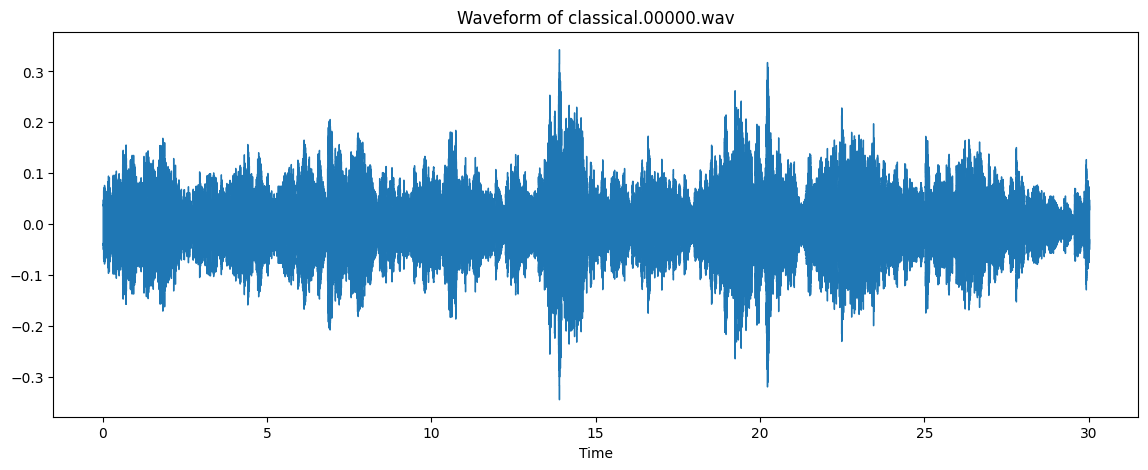

In [ ]:
y, sr = librosa.load(random_file_name, sr=44100)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of " + random_file_name.split("/")[-1])
plt.show()


In [ ]:
y.shape

(1323588,)

In [ ]:
from IPython.display import Audio

Audio(data=y, rate=sr)


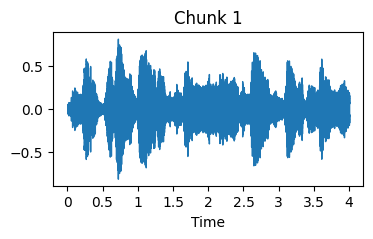

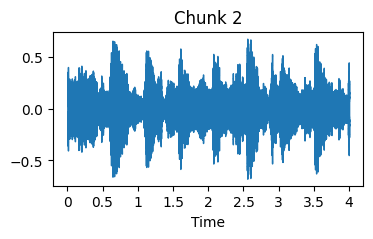

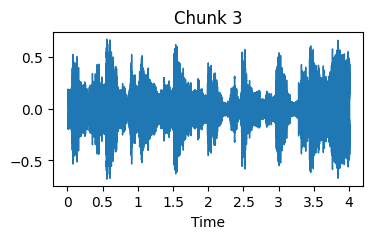

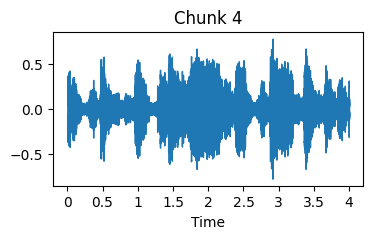

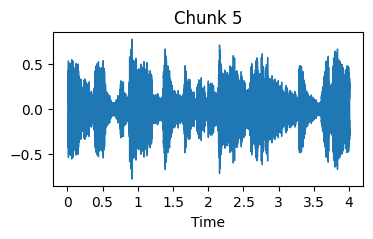

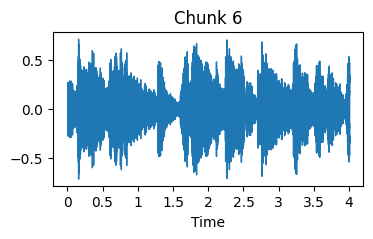

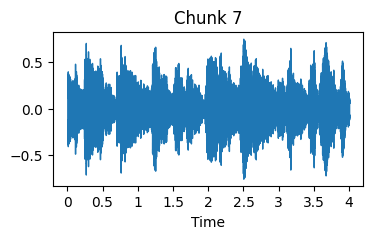

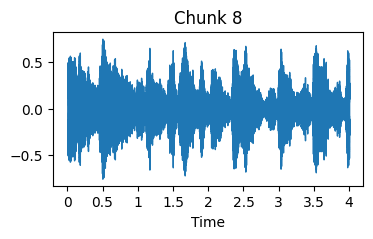

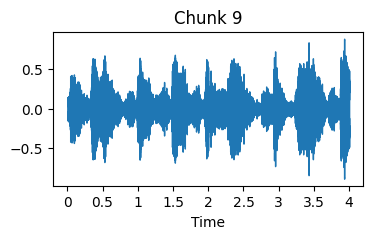

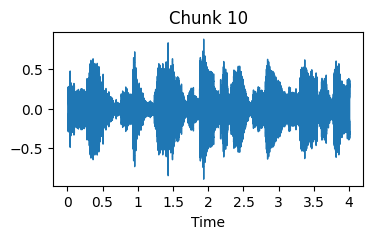

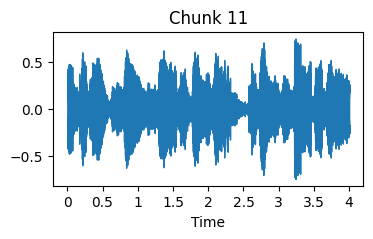

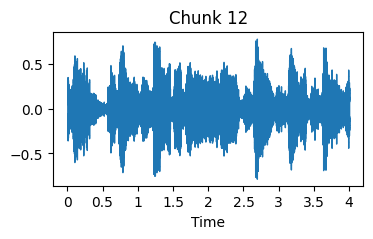

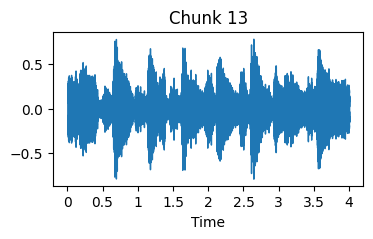

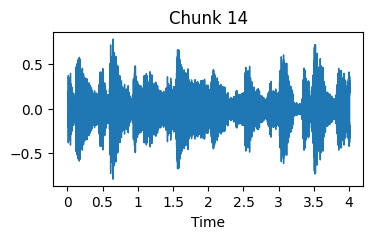

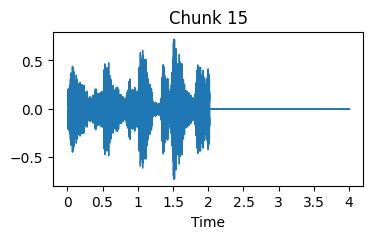

In [ ]:
audio_path = "/content/drive/MyDrive/GTZAN_dataset/Data/genres_original/blues/blues.00000.wav"
y, sr = librosa.load(audio_path, sr=None)  # Keep original sampling rate

# Define durations (in seconds)
chunk_duration = 4
overlap_duration = 2

# Convert to samples
chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr

# Calculate number of chunks
num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

# Plot each chunk
for i in range(num_chunks):
    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples
    chunk = y[start:end]
    if len(chunk) < chunk_samples:
        chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))

    plt.figure(figsize=(4, 2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.title(f"Chunk {i+1}")
    plt.show()


MELSPECTROGRAM VISUALISATION


In [ ]:
def plot_melespectrogram(y,sr):
    #Compute spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr)
    #Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
    #Visualize the spectrogram
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()

In [ ]:
random_file_name = "/content/drive/MyDrive/GTZAN_dataset/Data/genres_original/blues/blues.00000.wav"
y, sr = librosa.load(random_file_name, sr=44100)


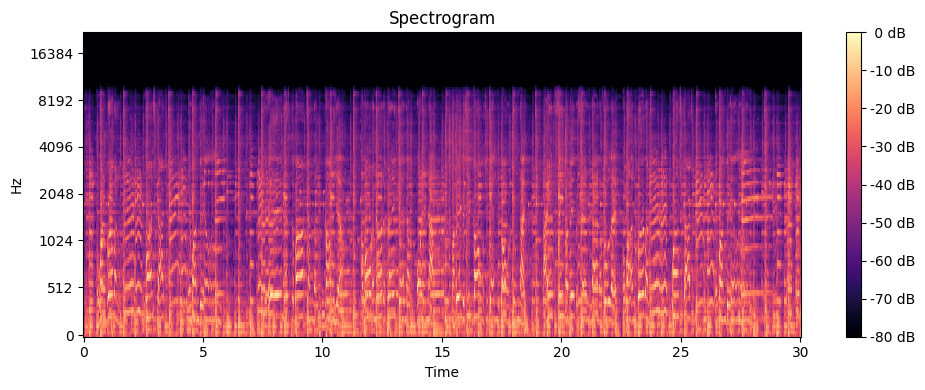

In [ ]:
plot_melespectrogram(y,sr)

In [ ]:
def plot_melspectrogram_chunks(y, sr):
    # Define the duration of each chunk and overlap (seconds)
    chunk_duration = 4
    overlap_duration = 2

    # Convert duration to samples
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    # Calculate number of chunks
    num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

    # Iterate over each chunk
    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples

        # Extract the chunk audio
        chunk = y[start:end]

        # Pad if last chunk is shorter than chunk_samples
        if len(chunk) < chunk_samples:
            chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))

        # Compute Mel spectrogram
        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        print("Spectrogram shape:", spectrogram.shape)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        # Visualize
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title(f"Chunk {i+1}")
        plt.tight_layout()
        plt.show()


In [ ]:
random_file_name = "/content/drive/MyDrive/GTZAN_dataset/Data/genres_original/blues/blues.00000.wav"
y, sr = librosa.load(random_file_name, sr=44100)

Spectrogram shape: (128, 345)


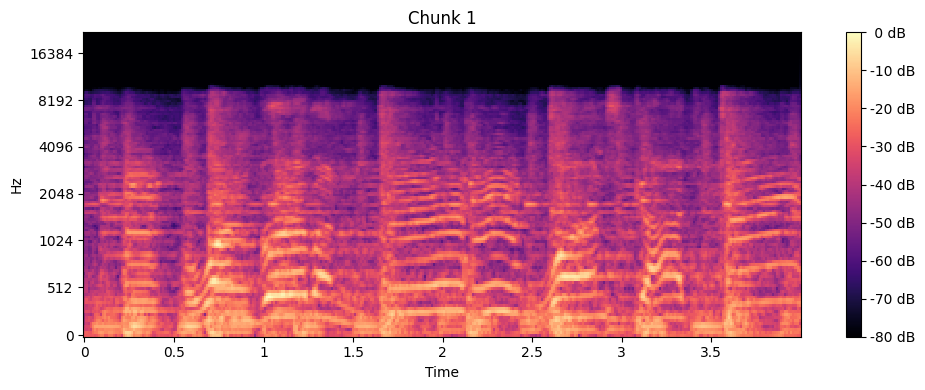

Spectrogram shape: (128, 345)


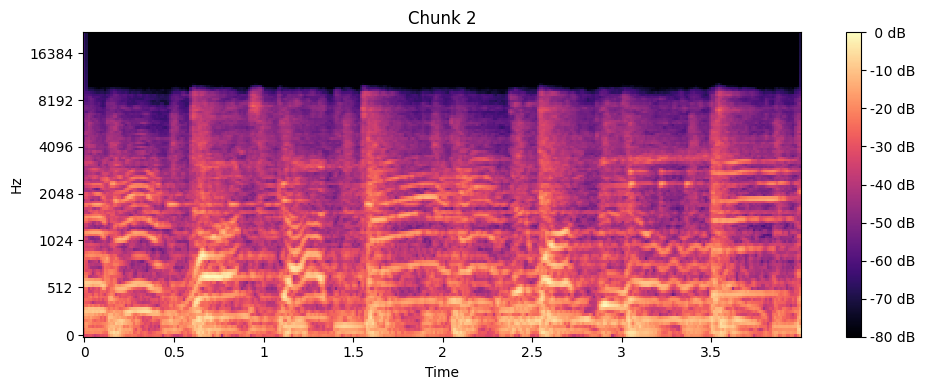

Spectrogram shape: (128, 345)


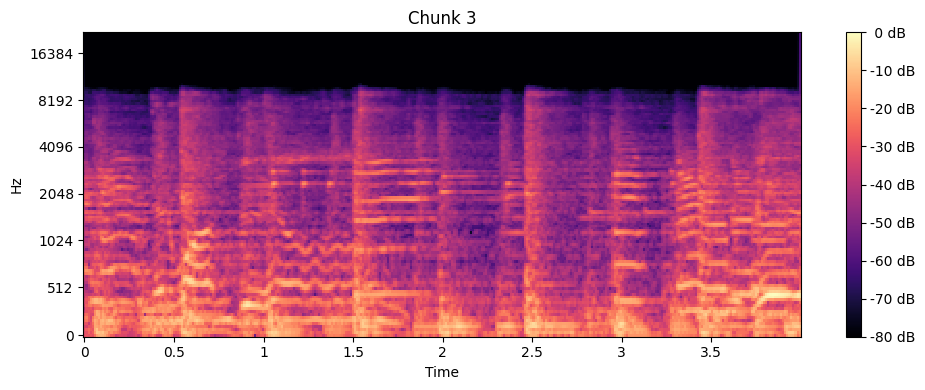

Spectrogram shape: (128, 345)


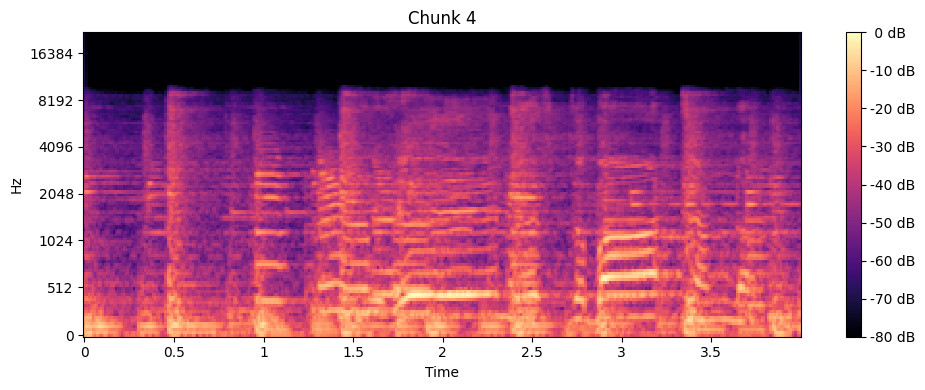

Spectrogram shape: (128, 345)


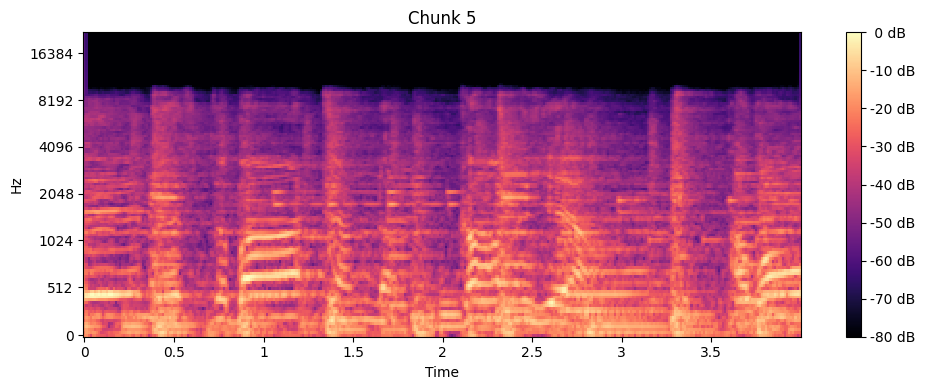

Spectrogram shape: (128, 345)


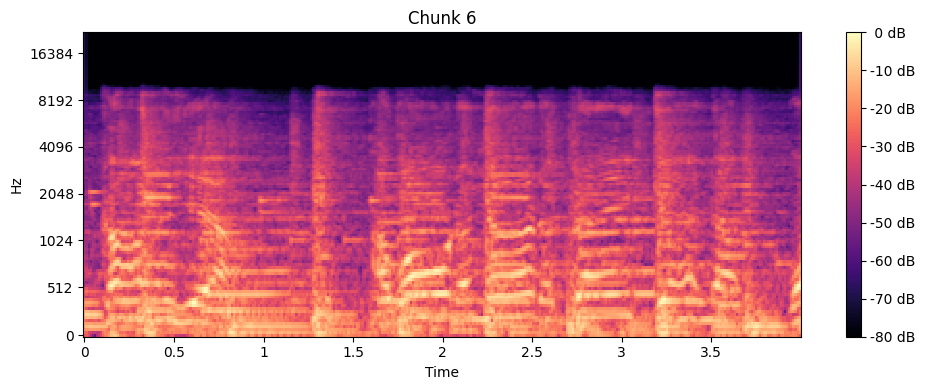

Spectrogram shape: (128, 345)


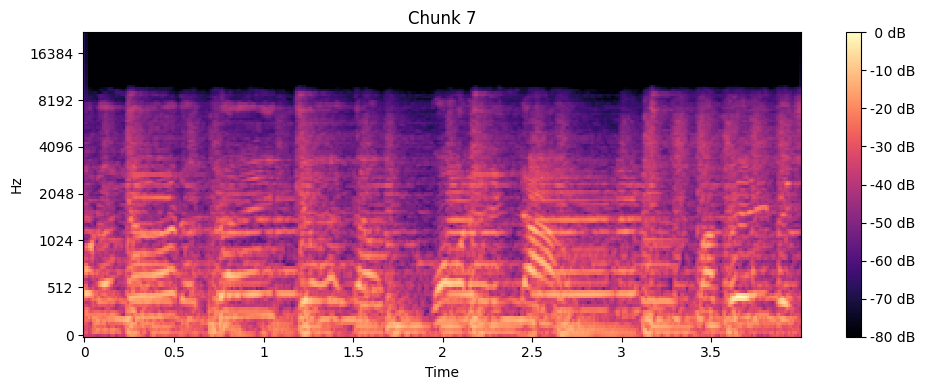

Spectrogram shape: (128, 345)


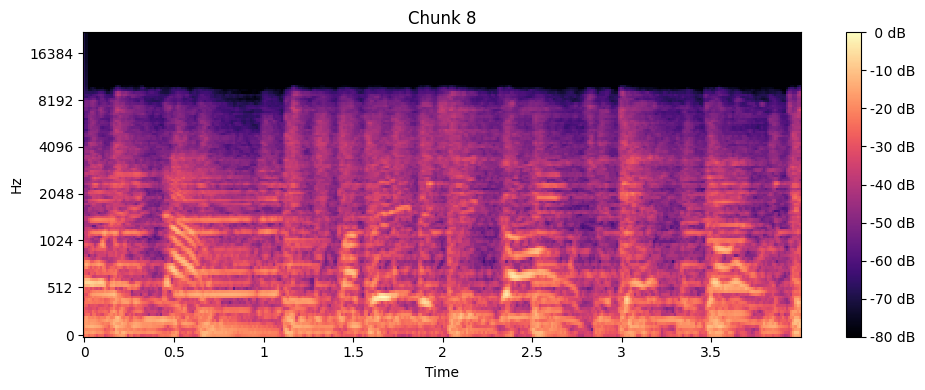

Spectrogram shape: (128, 345)


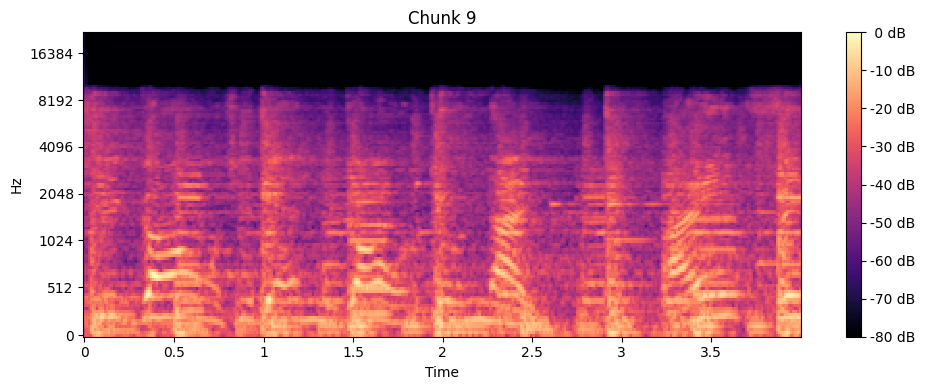

Spectrogram shape: (128, 345)


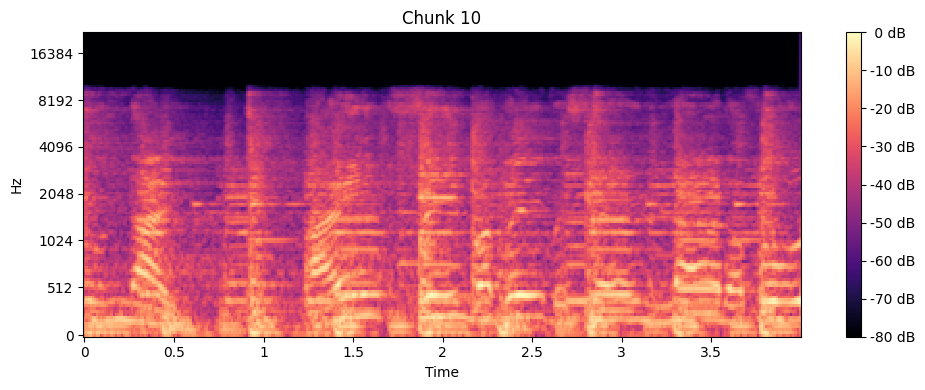

Spectrogram shape: (128, 345)


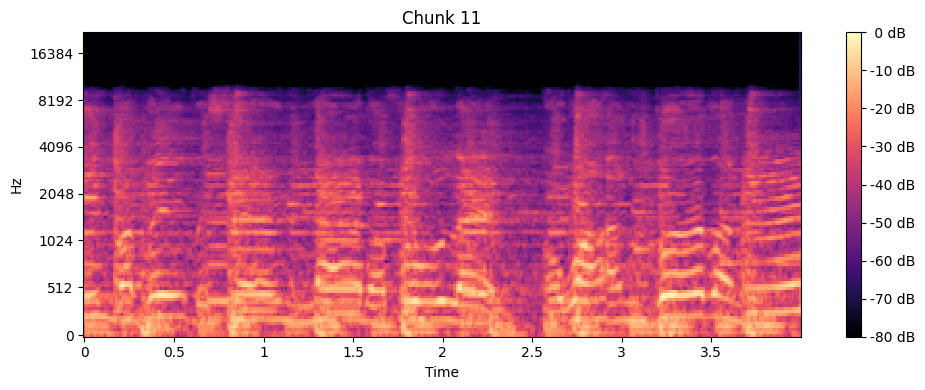

Spectrogram shape: (128, 345)


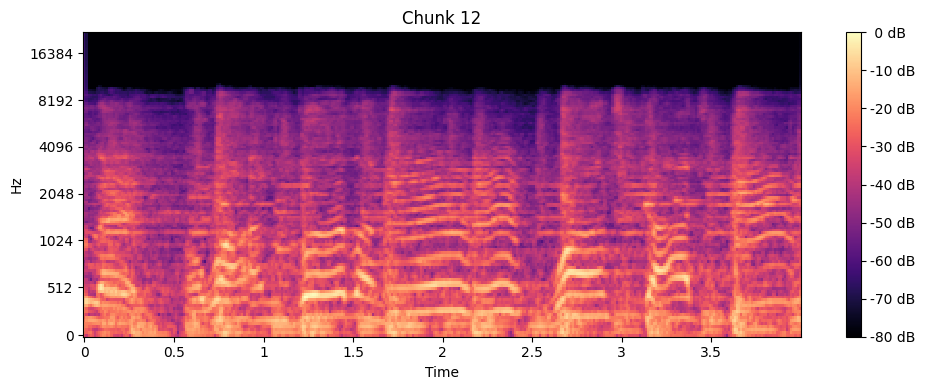

Spectrogram shape: (128, 345)


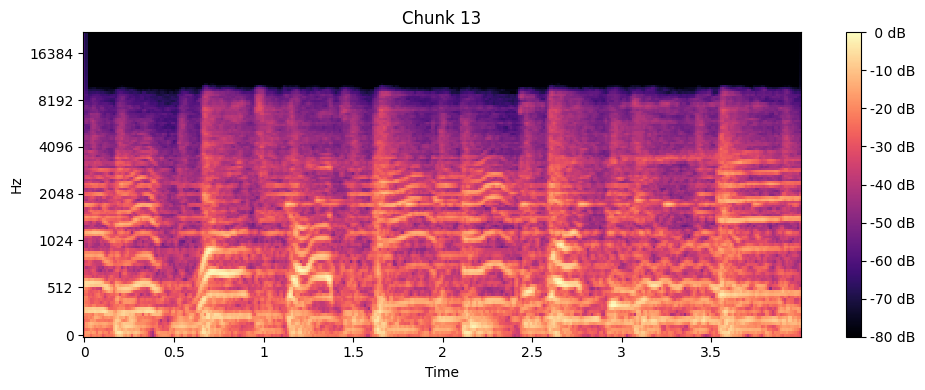

Spectrogram shape: (128, 345)


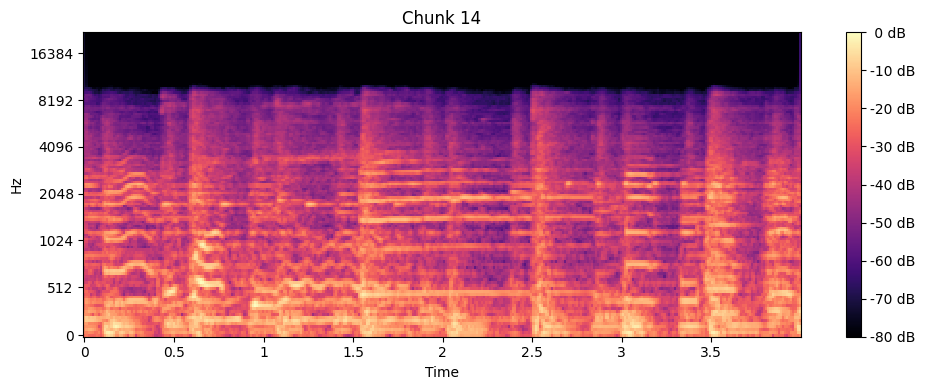

Spectrogram shape: (128, 345)


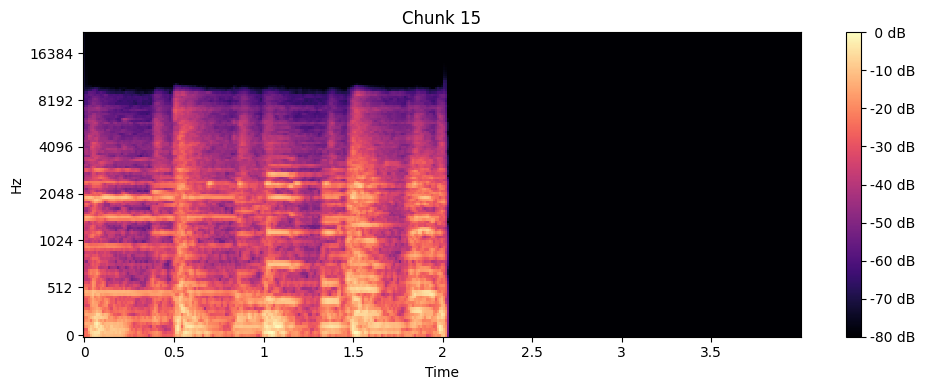

In [ ]:
plot_melspectrogram_chunks(y, sr)

DATA PREPROCESSING

In [ ]:
data_dir = "/content/drive/MyDrive/GTZAN_dataset/Data/genres_original"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']


In [ ]:
import tensorflow as tf
from tensorflow.image import resize
def load_and_preprocess_data(data_dir, classes, target_shape=(150,150)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing --", class_name)

        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)

                # Define chunk duration and overlap
                chunk_duration = 4
                overlap_duration = 2

                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

                for i in range(num_chunks):
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    chunk = audio_data[start:end]

                    # Pad last chunk if shorter
                    if len(chunk) < chunk_samples:
                        chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))

                    # Mel spectrogram
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

                    # Resize using TensorFlow
                    mel_spectrogram = tf.convert_to_tensor(np.expand_dims(mel_spectrogram, axis=-1), dtype=tf.float32)
                    mel_spectrogram = resize(mel_spectrogram, target_shape)

                    data.append(mel_spectrogram.numpy())  # convert back to NumPy array
                    labels.append(i_class)

    return np.array(data), np.array(labels)


In [ ]:
data, labels = load_and_preprocess_data(data_dir, classes)
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Processing -- blues
Processing -- classical
Processing -- country
Processing -- disco
Processing -- hiphop
Processing -- jazz
Processing -- metal
Processing -- pop
Processing -- reggae
Processing -- rock
Data shape: (14960, 150, 150, 1)
Labels shape: (14960,)


In [ ]:
print(data.shape)
print(labels.shape)

(14960, 150, 150, 1)
(14960,)


In [ ]:
from tensorflow.keras.utils import to_categorical

labels = to_categorical(labels, num_classes=len(classes))


In [ ]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
labels.shape

(14960, 10)

SPLITTING DATASET INTO TRAINING AND TEST SETS

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)


In [ ]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_test:", Y_test.shape)


X_train: (11968, 150, 150, 1)
X_test: (2992, 150, 150, 1)
Y_train: (11968, 10)
Y_test: (2992, 10)


BUILDING A CNN MODEL

In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
X_train[0].shape

(150, 150, 1)

In [ ]:
from tensorflow.keras.models import Sequential


model = Sequential()

model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Conv2D(512, 3, activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(0.45))

model.add(Dense(len(classes), activation='softmax'))

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

training_history = model.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop]
)


Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.1283 - loss: 2.2595 - val_accuracy: 0.3429 - val_loss: 1.8293
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.3800 - loss: 1.6506 - val_accuracy: 0.5478 - val_loss: 1.2867
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.5530 - loss: 1.2309 - val_accuracy: 0.6688 - val_loss: 0.9735
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.6559 - loss: 0.9732 - val_accuracy: 0.7025 - val_loss: 0.8514
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7084 - loss: 0.8265 - val_accuracy: 0.7557 - val_loss: 0.6942
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7586 - loss: 0.6736 - val_accuracy: 0.8082 - val_loss: 0.5710
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.8141 - loss: 0.5482 - val_accuracy: 0.8456 - val_loss: 0.4577
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.8476 - loss: 0.4389 - 

In [ ]:
model.save("/content/drive/MyDrive/Trained_model.h5")  # Save directly to Drive


In [ ]:
training_history.history


{'accuracy': [0.18524397909641266,
  0.4317346215248108,
  0.5842245817184448,
  0.6701202988624573,
  0.7198362350463867,
  0.765625,
  0.8179311752319336,
  0.8492646813392639,
  0.8823529481887817,
  0.8960561752319336,
  0.9168616533279419,
  0.9338235259056091,
  0.9496156573295593,
  0.9547125697135925,
  0.9541276693344116,
  0.9618983864784241,
  0.9695855379104614,
  0.9713402390480042,
  0.9761029481887817,
  0.9771891832351685,
  0.975685179233551,
  0.982536792755127,
  0.9814505577087402],
 'loss': [2.10779070854187,
  1.5092856884002686,
  1.1498173475265503,
  0.9352609515190125,
  0.7894772887229919,
  0.6633883118629456,
  0.5380229353904724,
  0.4328663945198059,
  0.3491987884044647,
  0.3018287718296051,
  0.24307285249233246,
  0.19635803997516632,
  0.15085403621196747,
  0.13688749074935913,
  0.1278020739555359,
  0.1104392260313034,
  0.09414394199848175,
  0.08090029656887054,
  0.06860700249671936,
  0.06994923949241638,
  0.06743364036083221,
  0.05486634746

In [ ]:
import json

with open('training_hist.json', 'w') as f:
    json.dump(training_history.history, f)


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Trained_model.keras")

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,547,376 (82.20 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,364,918 (54.80 MB)

In [ ]:
#Reloading Training history
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)

In [ ]:
training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

MODEL EVALUATION - I

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, Y_train)


374/374 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9967 - loss: 0.0198


In [ ]:
train_loss,train_accuracy

(0.019340306520462036, 0.9964070916175842)

In [ ]:
#Model evaluation on Validation set
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9296 - loss: 0.2255


In [ ]:

val_loss,val_accuracy

(0.21746040880680084, 0.9318181872367859)

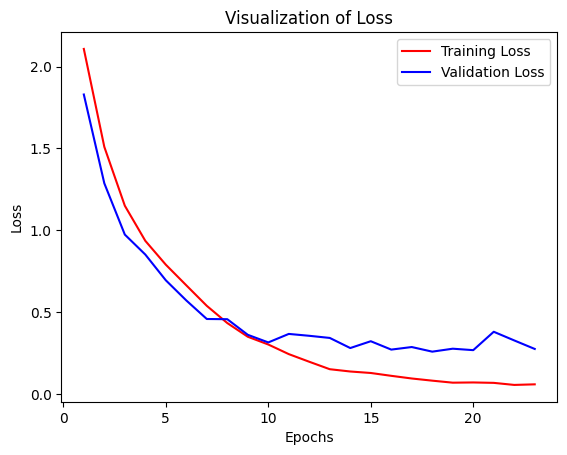

In [ ]:
# Number of epochs
epochs = [i for i in range(1, 24)]

# Use the actual training history dictionary
plt.plot(epochs, training_history_data['loss'], label="Training Loss", color='red')
plt.plot(epochs, training_history_data['val_loss'], label="Validation Loss", color='blue')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss")
plt.legend()
plt.show()

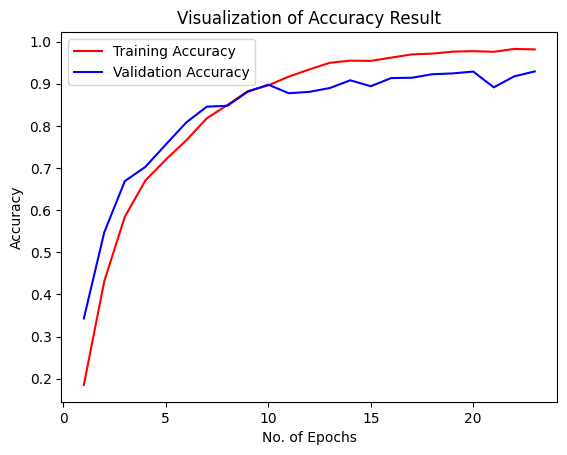

In [ ]:
#Visualization of Accuracy
epochs = [i for i in range(1,24)]
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

PRECISION, RECALL, ACCURACY, F1SCORE - MODEL EVALUATION - II

In [ ]:
X_test.shape


(2992, 150, 150, 1)

In [ ]:
y_pred = model.predict(X_test)
y_pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


array([[1.75045524e-02, 1.14829732e-06, 9.82411027e-01, ...,
        7.04114996e-07, 4.31506451e-05, 1.39860031e-05],
       [4.64057273e-08, 4.59246939e-06, 1.30304238e-06, ...,
        1.12566973e-07, 1.31056677e-05, 9.98728812e-01],
       [1.13407931e-16, 2.08539661e-17, 1.49917113e-15, ...,
        1.54914247e-04, 5.08308373e-09, 2.21402952e-12],
       ...,
       [2.99575458e-05, 1.27881572e-06, 9.97259259e-01, ...,
        9.17004641e-08, 4.15702561e-06, 2.70319870e-03],
       [9.99223351e-01, 1.81812297e-07, 1.37748852e-08, ...,
        3.75083881e-10, 2.12992836e-06, 4.26976658e-06],
       [6.26872713e-03, 7.43686140e-01, 6.91971695e-03, ...,
        4.12400207e-03, 1.29513275e-02, 3.09810275e-03]], dtype=float32)

In [ ]:
y_pred.shape

(2992, 10)

In [ ]:
predicted_categories = np.argmax(y_pred,axis=1)
predicted_categories

array([2, 9, 4, ..., 2, 0, 1])

In [ ]:
Y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:

Y_test.shape

(2992, 10)

In [ ]:
true_categories = np.argmax(Y_test,axis=1)
true_categories

array([2, 9, 4, ..., 2, 0, 1])

In [ ]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

              precision    recall  f1-score   support

       blues       0.95      0.90      0.92       305
   classical       0.95      0.98      0.97       300
     country       0.92      0.87      0.89       324
       disco       0.94      0.93      0.94       307
      hiphop       0.94      0.98      0.96       285
        jazz       0.96      0.94      0.95       308
       metal       0.98      0.97      0.98       319
         pop       0.92      0.93      0.92       283
      reggae       0.94      0.92      0.93       283
        rock       0.83      0.90      0.86       278

    accuracy                           0.93      2992
   macro avg       0.93      0.93      0.93      2992
weighted avg       0.93      0.93      0.93      2992



In [ ]:
cm

array([[275,   1,   6,   6,   1,   1,   1,   0,   6,   8],
       [  0, 295,   2,   0,   0,   2,   0,   0,   0,   1],
       [  5,   2, 281,   1,   0,   4,   0,   7,   1,  23],
       [  0,   2,   3, 286,   2,   0,   0,   7,   3,   4],
       [  0,   0,   0,   0, 279,   0,   0,   3,   2,   1],
       [  6,   9,   1,   0,   0, 289,   0,   1,   0,   2],
       [  0,   0,   0,   1,   1,   0, 310,   0,   0,   7],
       [  0,   1,   6,   1,   7,   0,   0, 263,   4,   1],
       [  2,   1,   1,   6,   6,   2,   0,   1, 259,   5],
       [  2,   0,   7,   3,   2,   2,   5,   4,   2, 251]])

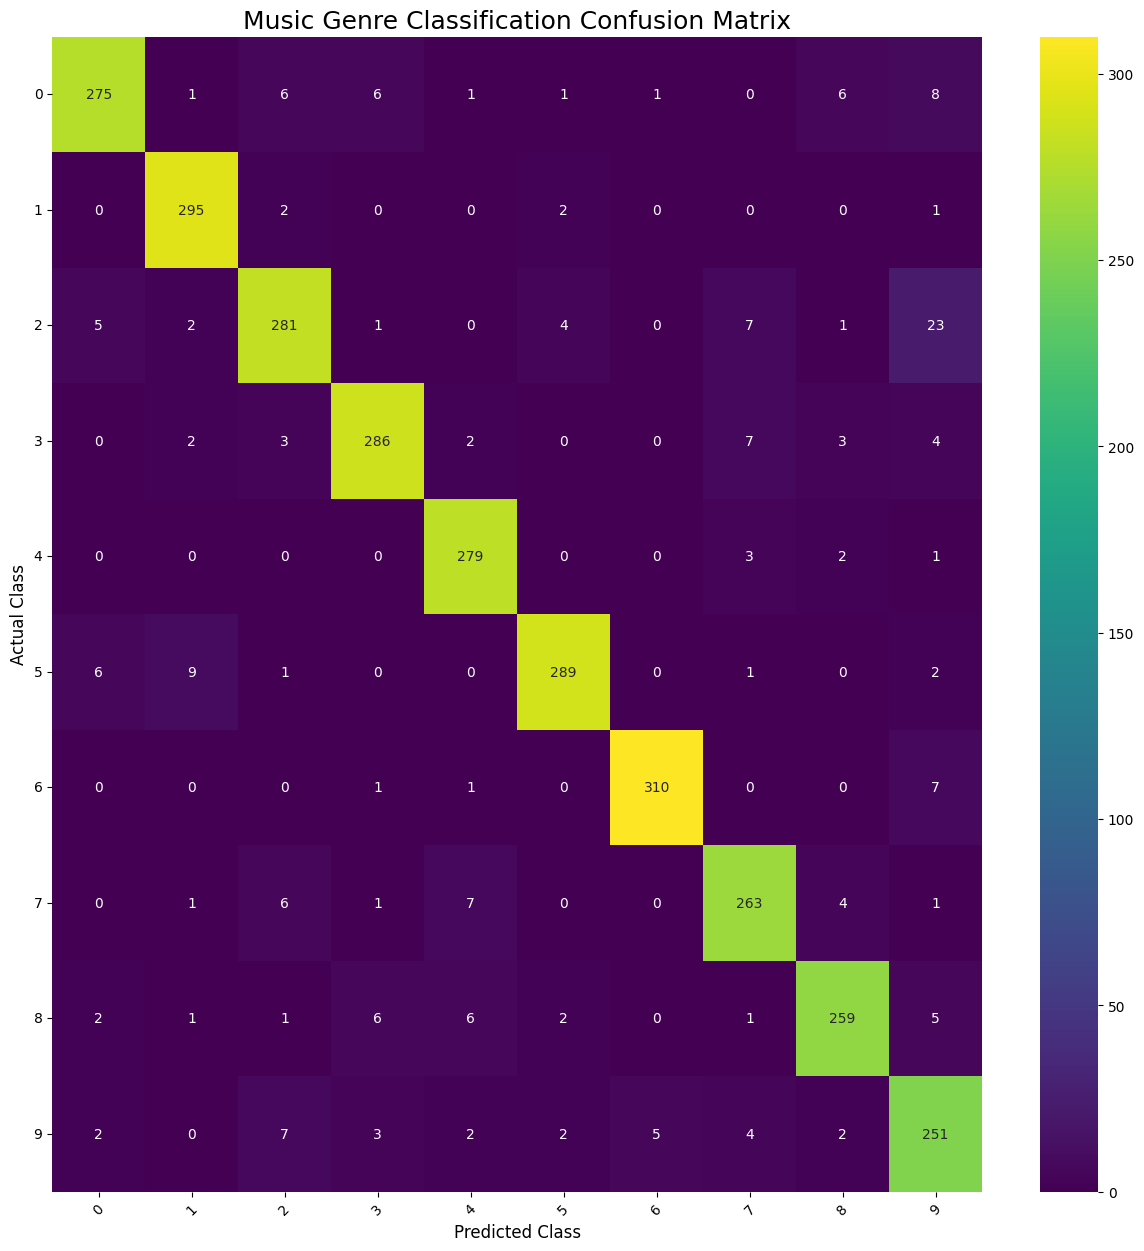

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

# Modern colormap: 'viridis', 'magma', 'coolwarm', 'cividis'
sns.heatmap(cm, annot=True, annot_kws={"size":10}, fmt='d', cmap='viridis', cbar=True)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Music Genre Classification Confusion Matrix", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
